In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimisation with Stochastic Gradient Descent

The reaction rates of the circuits can be directly optimised with the automatic differentiation provided by jax

In [154]:
from datetime import datetime 
import jax 
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optax
from scipy.special import factorial
import diffrax as dfx
from functools import partial
from bioreaction.misc.misc import flatten_listlike
from synbio_morpher.utils.results.analytics.timeseries import get_sensitivity, get_precision, get_peaks

jax.config.update('jax_platform_name', 'gpu')

rng = jax.random.PRNGKey(0)

np.random.seed(0)


In [155]:
def processor(input, funcs):
    for func in funcs:
        if type(input) == tuple:
            input = func(*input)
        else:
            input = func(input)
    return input


In [156]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


# ODE Terms
def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             #  signal, signal_onehot: jnp.ndarray,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)  # + signal(t) * signal_onehot


def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5,
                                 stepsize_controller=dfx.ConstantStepSize()):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates.squeeze(), reverse_rates=reverse_rates.squeeze()
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0.squeeze(),
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=stepsize_controller)


def f(reverse_rates, y0, t0, t1, dt0,
      inputs, outputs, forward_rates):
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    # ys = s.ys[:np.argmax(s.ts >= np.inf), :]
    # ts = s.ts[:np.argmax(s.ts >= np.inf)]

    return ys


def f2(eqconstants, y0, t0, t1, dt0,
       inputs, outputs, forward_rates):
    
    reverse_rates = forward_rates / eqconstants
    s = bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                     inputs, outputs, forward_rates, reverse_rates,
                                     saveat=dfx.SaveAt(ts=np.linspace(t0, t1, 100)))
    ys = s.ys
    return ys


# def cost_f(ys, output_idxs):
#     cost = jnp.sum(jnp.abs(jnp.max(ys, axis=0)[
#         output_idxs] - ys[-1, output_idxs]))
#     return -cost


def cost_f(ys, signal_idx, output_idxs):
    peaks = get_peaks(ys[0, :], ys[-1, :], jnp.max(ys, axis=0), jnp.min(ys, axis=0))
    sens = get_sensitivity(signal_idx=signal_idx,
                           starting_states=ys[0, :], peaks=peaks)
    cost = -jnp.prod(sens[output_idxs])
    return cost

In [157]:
n_species = 3
n_circuits = 100
n_reactions = np.sum(np.arange(n_species+1))
tot_species = n_species + n_reactions
signal_idxs = np.array([0])
output_idxs = np.array([1, 2])
signal_onehot = np.zeros(tot_species)
signal_onehot[signal_idxs] = 1
signal_target = 2
y0 = np.array([200.0] * n_species + [0.0] * n_reactions) # [None, :] * np.ones((n_circuits, 1))
k1 = 0.00150958097
t0, t1, dt0 = 0, 20, 0.001
inputs, outputs = np.zeros((n_reactions, tot_species)), np.zeros(
    (n_reactions, tot_species))
inds = flatten_listlike([[(i, j) for j in range(i, n_species)]
                        for i in range(n_species)])
for i in range(n_reactions):
    inputs[i, inds[i][0]] += 1
    inputs[i, inds[i][1]] += 1
    outputs[i, i+n_species] += 1
    
forward_rates = np.ones(n_reactions) * k1
# eqconstants = np.power(10, np.random.normal(0, 1, (n_circuits, n_reactions)))
eqconstants_exps = (np.random.rand(n_circuits, n_reactions) - 0.5) * 5
eqconstants = np.power(10, eqconstants_exps)
reverse_rates = k1 / eqconstants


### Steady states + perturbation

In [158]:
f_t = partial(f2, y0=y0, t0=t0, t1=t1, dt0=dt0, inputs=inputs, outputs=outputs, forward_rates=forward_rates)
y_steady = jax.vmap(f_t)(k1 / eqconstants)
y_perturbed = y_steady[:, -1, :] * (signal_onehot == 0) + y_steady[:, -1, :] * (signal_onehot == 1) * signal_target


In [159]:
def mod_input(ys, y_starting):
    return 

def sim_wrapper(circuit_params, yp, y0, f_t):
    ys = f_t(circuit_params, yp)
    return jnp.concatenate([y0, ys], axis=0)
    
f_t = partial(f2, t0=t0, t1=t1, dt0=dt0, inputs=inputs, outputs=outputs, forward_rates=forward_rates)
c_t = partial(cost_f, signal_idx=signal_idxs, output_idxs=output_idxs)
sim_chain = [partial(sim_wrapper, f_t = f_t), c_t]
f_full = partial(processor, funcs = sim_chain)

In [160]:
[i.shape for i in (k1 / eqconstants, y_perturbed, y_steady[:, -1, :][:, None, :])]

[(100, 6), (100, 9), (100, 1, 9)]

In [161]:
# Test it
cost = jax.vmap(f_full)((k1 / eqconstants, y_perturbed, y_steady[:, -1, :][:, None, :]))
cost


Array([-3.74779949e-04, -8.14218481e-07, -1.59318708e-02, -3.15788952e-06,
       -8.58016487e-04, -9.80248973e-02, -3.05806316e-04, -1.26141887e-02,
       -3.61908879e-03, -3.93633207e-04, -3.89522524e-04, -1.03264989e-03,
       -2.05145385e-02, -4.45978865e-02, -1.34347286e-02, -3.97268264e-03,
       -1.33137987e-03, -2.03931751e-03, -1.26006917e-05, -3.93822818e-04,
       -2.75217462e-03, -1.15225026e-04, -3.25845380e-04, -1.85427966e-03,
       -2.28660274e-03, -7.82217365e-03, -2.21773125e-02, -1.02044925e-01,
       -5.09947576e-02, -9.91834253e-02, -9.85090228e-05, -9.28436348e-04,
       -8.42057576e-04, -2.05614022e-03, -4.72011714e-04, -6.22340329e-02,
       -1.06044300e-03, -1.44167512e-04, -4.42745537e-03, -1.32546539e-03,
       -1.66044030e-02, -3.40288877e-03, -2.54354556e-04, -8.71396512e-02,
       -4.72545289e-02, -2.67892070e-02, -1.09096791e-03, -2.15315986e-02,
       -4.73150052e-03, -7.77029479e-03, -3.72752063e-02, -5.64926956e-03,
       -2.94969388e-04, -

# Simulate

In [162]:
l2_reg_alpha = 0.1
learning_rate = 0.001
warmup_epochs = 5
epochs = 30
n_batches = 1
warmup_fn = optax.linear_schedule(
    init_value=0., end_value=learning_rate,
    transition_steps=warmup_epochs * n_batches)
cosine_epochs = max(epochs - warmup_epochs, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=0.01, decay_steps=1000) #, alpha=l2_reg_alpha)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[warmup_epochs * n_batches])
optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(reverse_rates[0])

In [163]:
def f_scan(inp, cr, f, yp, y0):
    c, r = cr
    circuit_params, optimiser_state = inp
    c, grads = jax.vmap(jax.value_and_grad(f, argnums=0))((circuit_params, yp, y0))
    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    new_circuit_params = optax.apply_updates(circuit_params, updates[0])
    # Slow down gradient if negatives appear
    new_circuit_params = jnp.where(new_circuit_params <= 0, optax.apply_updates(circuit_params, 0.01 * updates[0]), new_circuit_params)
    circuit_params = jnp.where(new_circuit_params <= 0, circuit_params / 10, new_circuit_params)
    return [circuit_params, optimiser_state], [c, circuit_params]

cs = np.zeros([epochs, n_circuits])
rs = np.zeros([epochs, *eqconstants.shape])

### Run simulation

In [164]:
# 3 mins
print('Predicted time:', 17.5/30 * epochs, 'mins')

start_time = datetime.now()
ro, crs = jax.lax.scan(partial(f_scan, f=f_full, yp=y_perturbed,
                       y0=y_steady[:, -1, :][:, None, :]), init=[eqconstants, optimiser_state], xs=[cs, rs])
print('Time:', datetime.now() - start_time)

all_eqconstants = np.concatenate([eqconstants[None, :, :], np.zeros_like(rs)])
fin_eqconstants, optimiser_state = ro
cs, all_eqconstants1 = crs
all_eqconstants[1:] = all_eqconstants1

Predicted time: 17.5 mins
Time: 0:17:57.637353


In [165]:
cs

Array([[-0.23094092, -0.2340735 , -3.7894425 , ..., -2.0421376 ,
        -0.1948771 , -0.30570018],
       [-0.23094092, -0.2340735 , -3.7894425 , ..., -2.0421376 ,
        -0.1948771 , -0.30570018],
       [-0.23094101, -0.23407434, -4.042731  , ..., -2.1068277 ,
        -0.3627604 , -0.30579683],
       ...,
       [-0.23103575, -0.23494521, -0.08684234, ..., -1.51883   ,
        -0.34988567, -0.8569315 ],
       [-0.23103985, -0.23498182, -0.08702804, ..., -1.5384877 ,
        -0.3501525 , -0.8583209 ],
       [-0.23104407, -0.23501815, -0.08721141, ..., -1.5480417 ,
        -0.35042045, -0.8597614 ]], dtype=float32)

In [166]:
all_eqconstants[-1]

array([[1.75374472e+00, 1.19109621e+01, 3.26450157e+00, 1.67670679e+00,
        4.20396775e-01, 5.36378717e+00],
       [4.81341988e-01, 9.09630508e+01, 2.08119995e+02, 2.75824338e-01,
        2.87491627e+01, 1.39497077e+00],
       [2.18838239e+00, 1.34271301e+02, 7.40587771e-01, 2.78977215e-01,
        3.71979065e+01, 4.60361748e+01],
       [2.45914288e+01, 7.08044815e+01, 2.47224609e+02, 3.13179131e+01,
        6.43724203e-01, 2.52723656e+01],
       [7.33594447e-02, 5.00731802e+00, 1.83106720e-01, 1.67241699e+02,
        1.28707302e+00, 3.89190912e-01],
       [1.68068373e+00, 2.35054436e+01, 6.07223868e-01, 2.19907665e+00,
        7.53535233e+01, 3.87426877e+00],
       [3.63469386e+00, 3.84299636e+00, 1.65478043e+02, 8.11150646e+00,
        2.21828446e-01, 4.86675352e-01],
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan, 

# Visualise

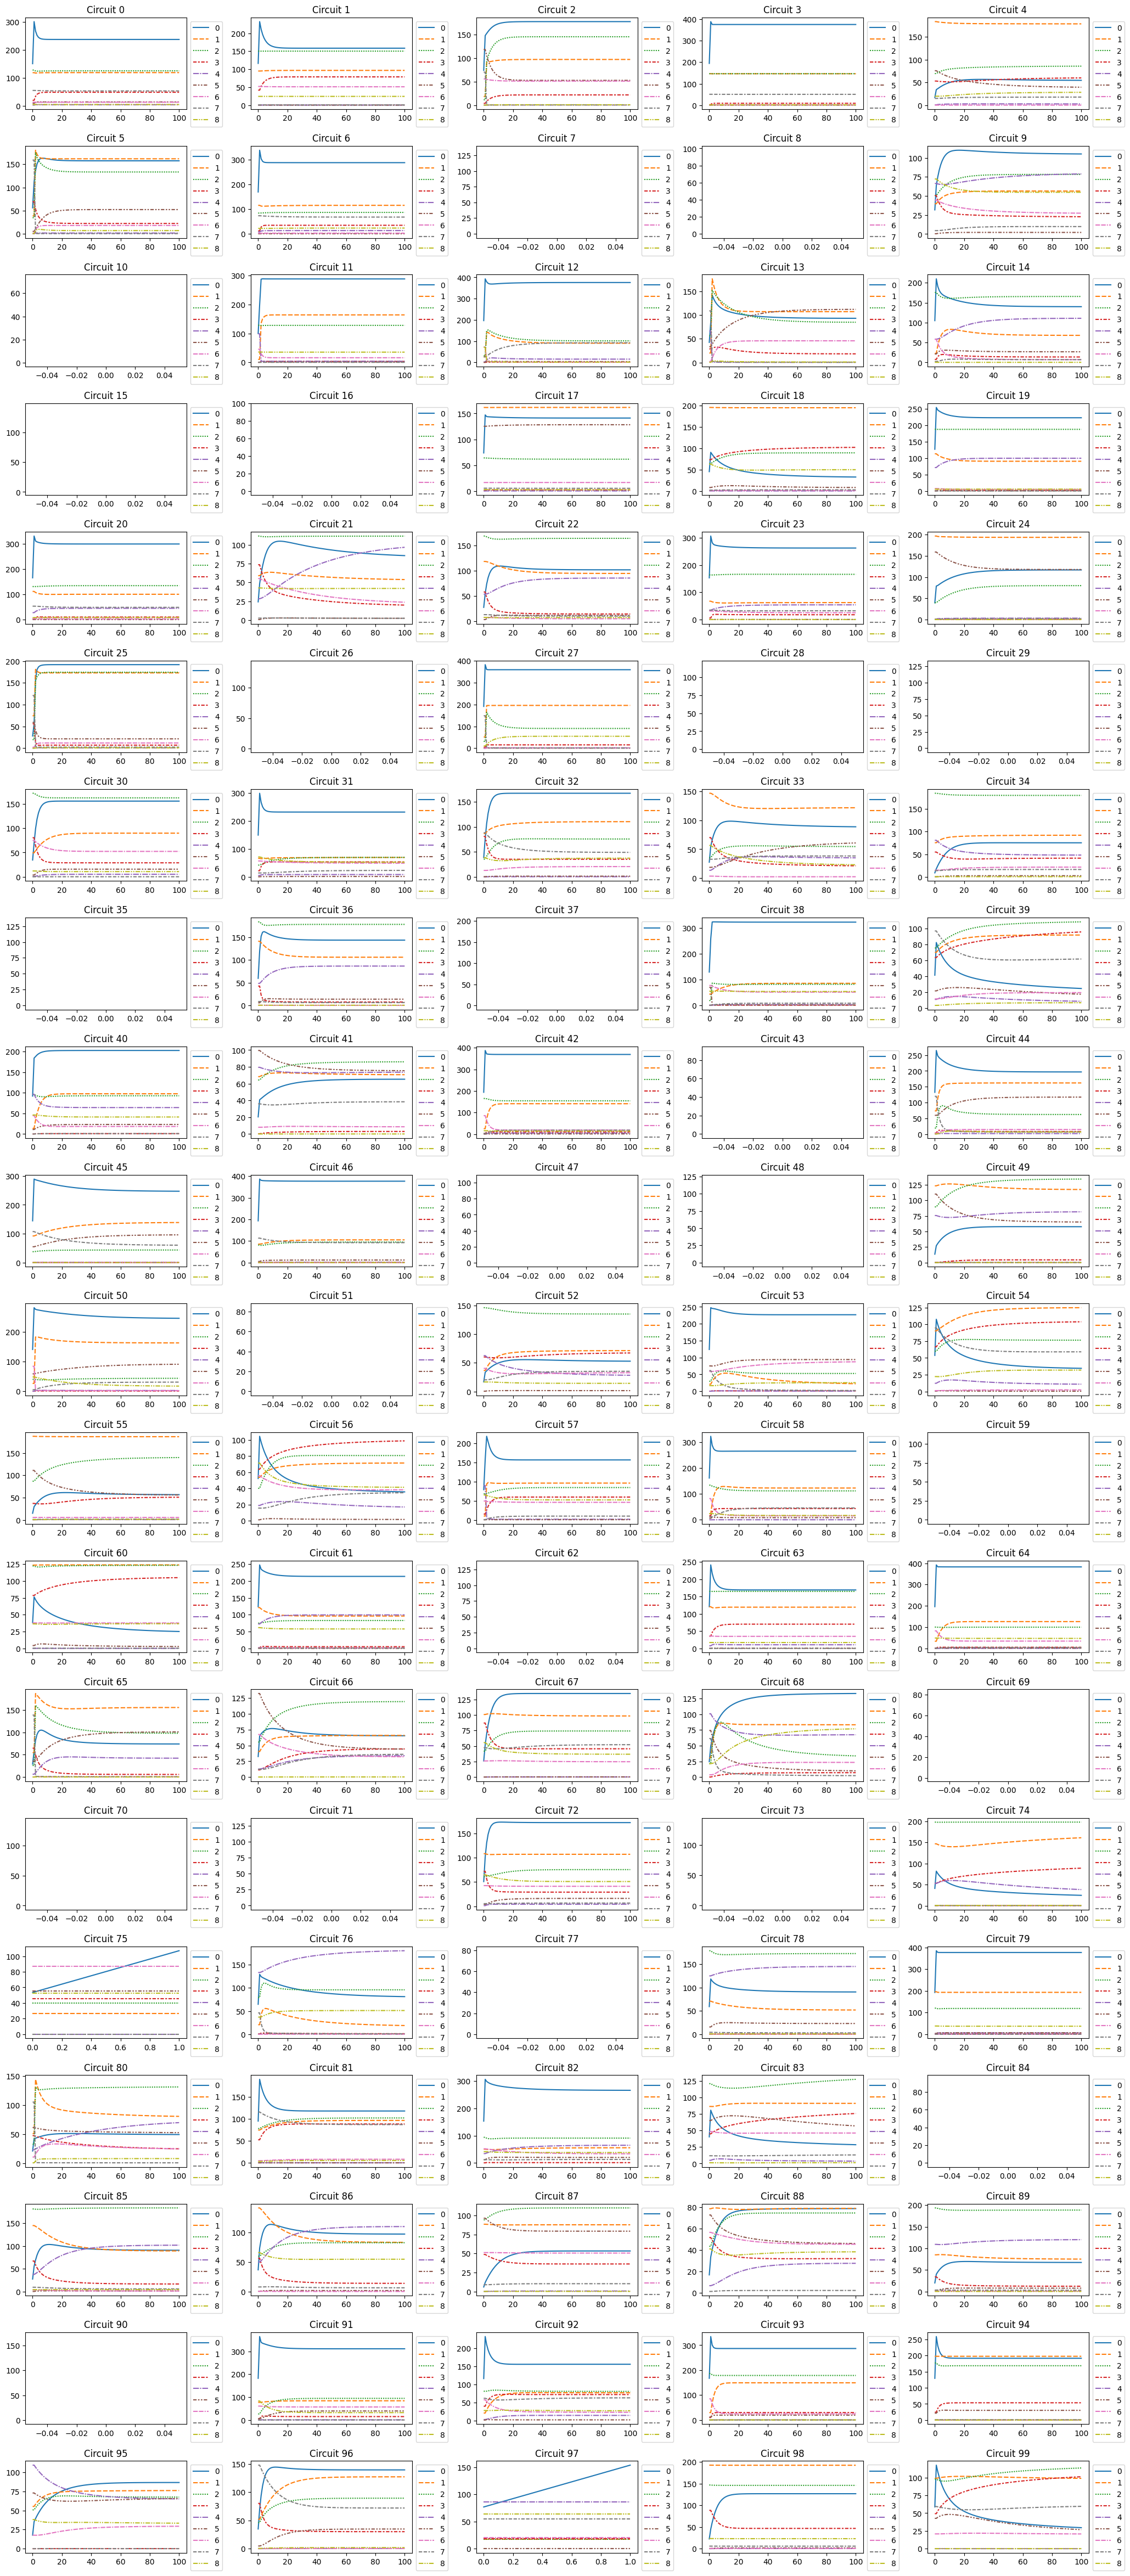

In [167]:
# ys = jax.vmap(f_t)(k1 / all_eqconstants[-1], y0=y_perturbed)
ys = jax.vmap(sim_chain[0])(k1 / all_eqconstants[-1], yp=y_perturbed, y0=y_steady[:, -1, :][:, None, :])
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for c, y in enumerate(ys):
    ax = plt.subplot(n_rows, n_cols, c+1)
    g = sns.lineplot(y, ax=ax)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Circuit {c}')

## Circuit param evolution

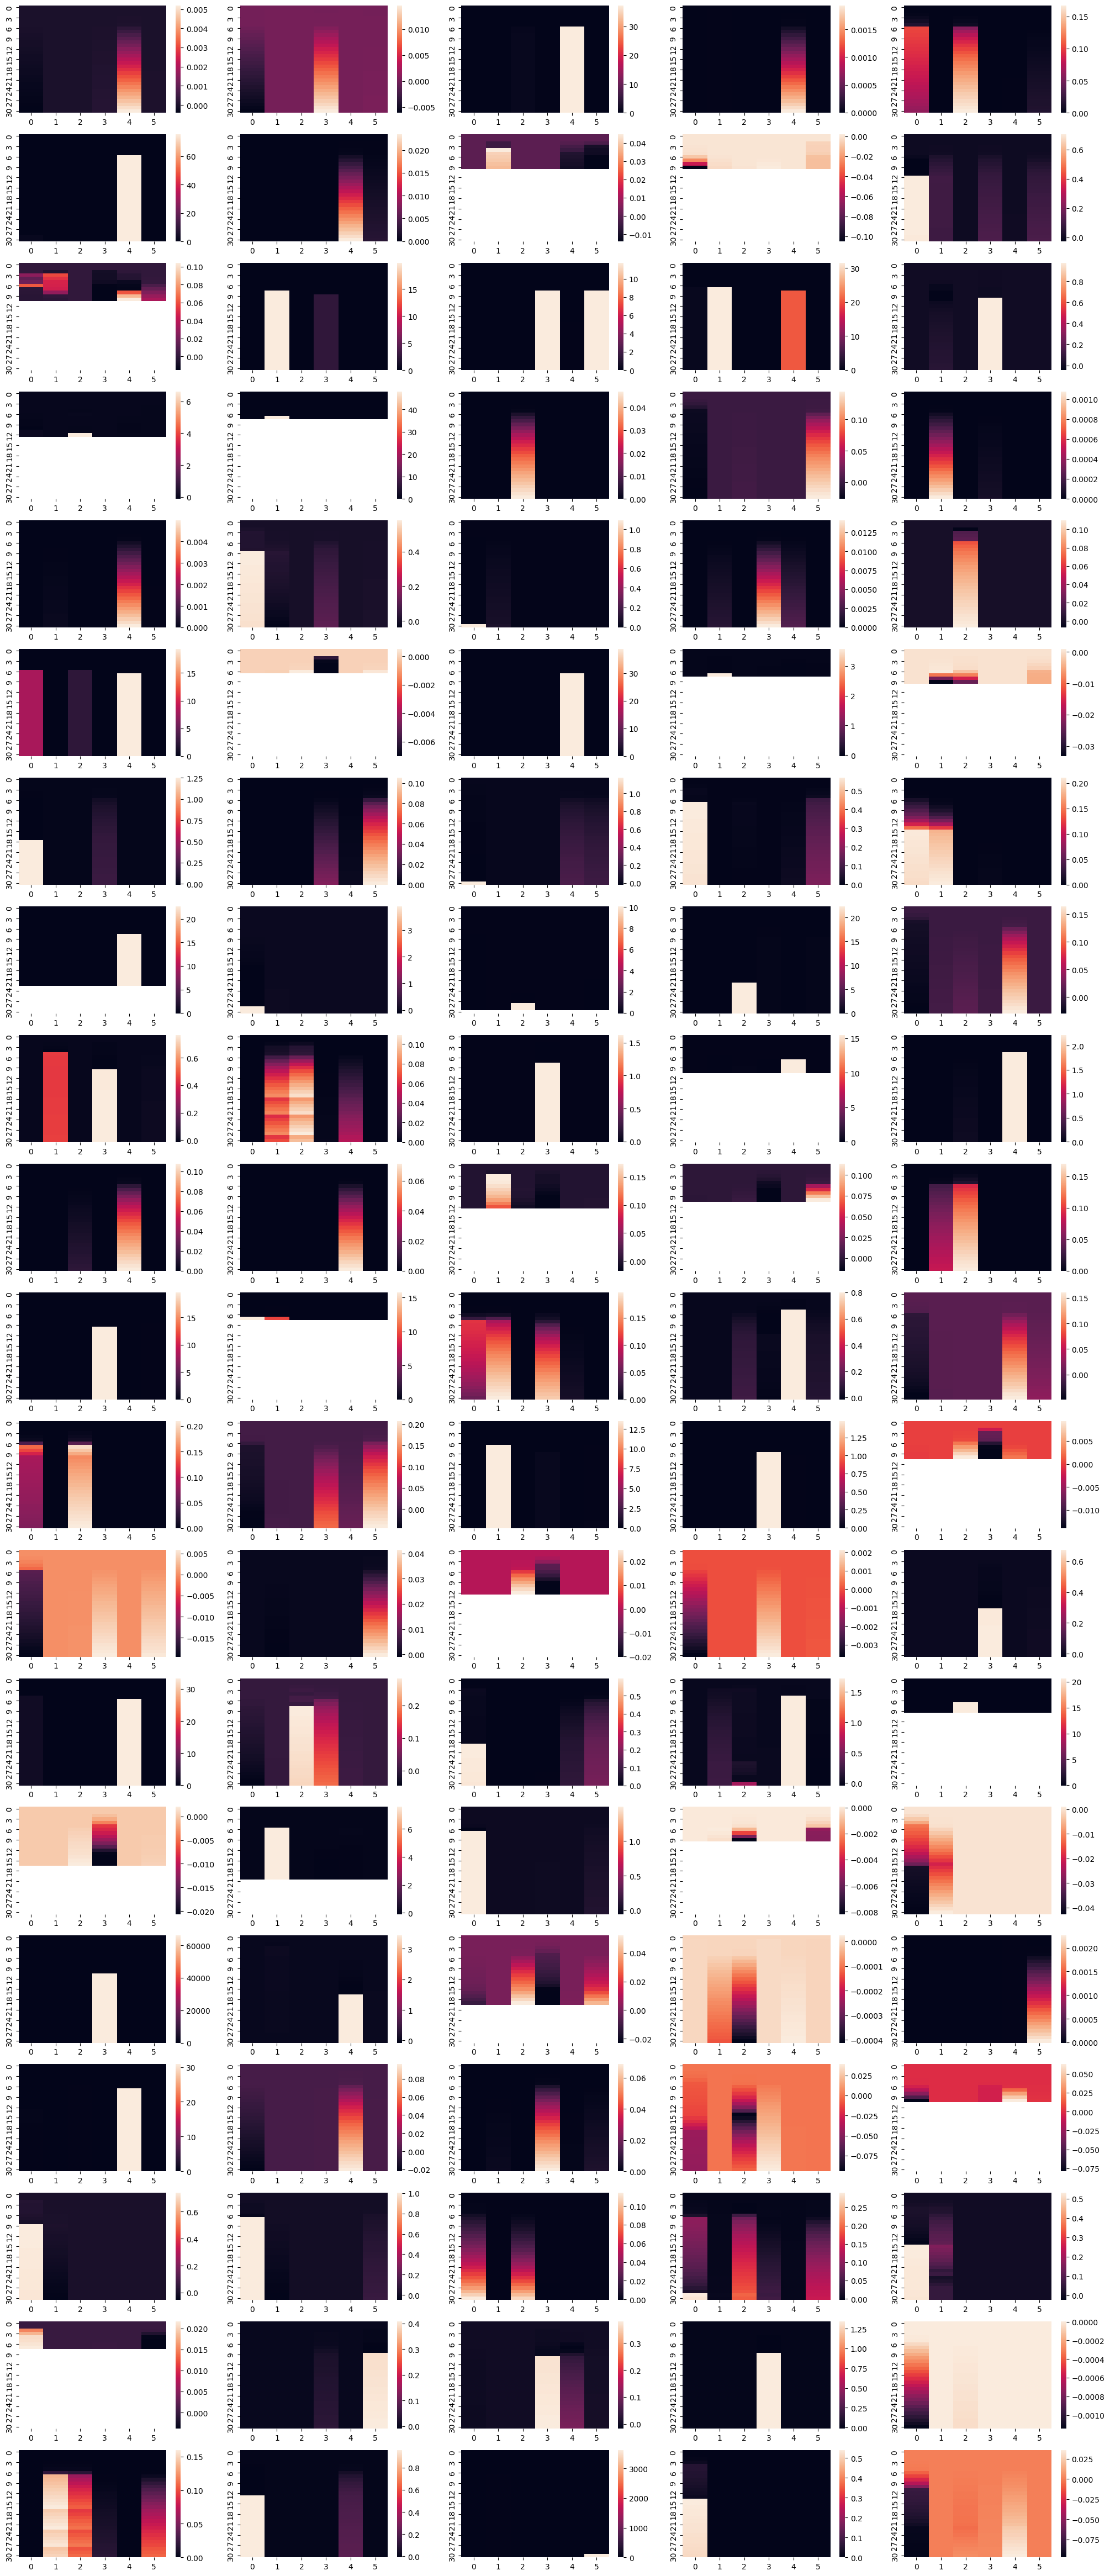

In [168]:
n_rows = n_circuits // 5 + (np.mod(n_circuits, 5) != 0)
n_cols = n_circuits // n_rows
fig = plt.figure(figsize=(5*n_cols, 3 * n_rows))
for c in range(n_circuits):
    ax = plt.subplot(n_rows, n_cols, c+1)
    sns.heatmap(all_eqconstants[:, c, :]) # - all_eqconstants[0, c, :])

## Costs

<Axes: >

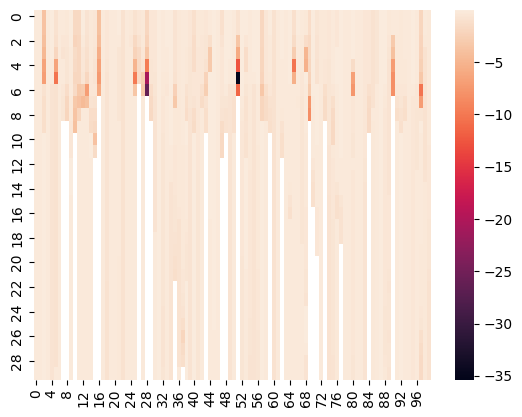

In [169]:
sns.heatmap(cs)

# Unpacked scan (for loop)

In [170]:
# cs = np.zeros([epochs, n_circuits])
# rs = np.zeros([epochs + 1, *reverse_rates.shape])
# rs[0] = reverse_rates
# inp = [reverse_rates, optimiser_state]
# for i, cr in enumerate(zip(cs, rs)):
#     if i == 1:
#         print(i)
#     inp, crs = f_scan(inp, cr)
#     fin_reverse_rates, optimiser_state = inp
#     cs[i] = np.array(crs[0])
#     rs[i+1] = crs[1]
#     if np.sum(np.isnan(rs[:, 3, :])) > 0:
#         print(rs)

In [171]:
# fig = plt.figure(figsize=(5*n_circuits, 3))
# for c in range(n_circuits):
#     ax = plt.subplot(1, n_circuits, c+1)
#     sns.heatmap(np.log10(rs[1:, c, :]))